In [1]:
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
#import cv2
import math
#https://pypi.org/project/python-mnist
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
%matplotlib inline
import matplotlib.pyplot as plt
import copy
from numpy import linalg
import time

l = len(images)
n = len(images[0])
m = int(np.sqrt(n))

def mnist(eps, p, q):
    p, q = np.float64(images[p]), np.float64(images[q])
    p, q = p / sum(p), q / sum(q)
    
    #Сергей: По-моему, это ошибка в старой статье, сумма будет не один
    #p = (1-eps/8)*(p + eps/n/(8-eps))
    #q = (1-eps/8)*(q + eps/n/(8-eps))
    
    p = (1-eps/8)*p + eps/(8*n)
    q = (1-eps/8)*q + eps/(8*n)
    
    #p, q = p.reshape(-1), q.reshape(-1)
    return p, q

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C /= np.max(C)
C.max()

1.0

In [2]:
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def mround(x):
    x += 1e-25
    r = p / x.dot(one)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q / (x.T).dot(one)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p - F.dot(one)
    err_c = q - (F.T).dot(one)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [3]:
def phi_(lamu):
    A = (-C/gamma + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))
    a = A.max()
    A-=a
    s = a+np.log(np.exp(A).sum())
    return gamma*(-lamu[:n].dot(p) - lamu[n:].dot(q) + s)

In [4]:
def sinkhorn(x0, min_iter=0, min_time=0):
    history_f = []
    history_time=[]

    u = x0[:n].copy()
    v = x0[n:].copy()
    start_time = time.perf_counter()
    k=0
    while True:
        logB = (-C/gamma + np.outer(u, one) + np.outer(one, v))
        max_logB =logB.max()
        logB_stable = logB - max_logB

        B_stable = np.exp(logB_stable)
        u_hat_stable, v_hat_stable = B_stable.dot(one), B_stable.T.dot(one)
        Bs_stable = u_hat_stable.sum()
        
        f_y = gamma*(-u.dot(p) - v.dot(q) + np.log(Bs_stable) + max_logB)
        
        if k%2==0:
            step = p/u_hat_stable
            u+=np.log(step/step.max())
        else:
            step = q/v_hat_stable
            v+=np.log(step/step.max())
         
        history_f.append(f_y)
        history_time.append(time.perf_counter() - start_time)
        
        if k > min_iter and history_time[-1] > min_time:
            break
        k-=-1
    return np.array(history_f), np.array(history_time)
    

In [5]:
def aam(x0, min_iter=0, min_time=0):
    L=1
    step = 2
    xi = np.zeros_like(x0)
    eta = xi.copy()
    zeta = xi.copy()
    eta_new = xi.copy()
    zeta_new = xi.copy()
    grad2 = alpha_new = alpha = 0

    
    f = lambda x: phi_(x)
    
    K=-C/gamma
    history_f = []
    history_time=[]
    
    i=0
    start_time = time.perf_counter()
    k=0
    while True:
        L_new = L/step
        while True:
            alpha_new = 1/2/L_new + np.sqrt(1/4/L_new/L_new + alpha*alpha*L/L_new)
            tau = 1/alpha_new/L_new
            xi = tau*zeta + (1-tau)*eta
            
            ##############
            logB = (K + np.outer(xi[:n], one) + np.outer(one, xi[n:]))
            max_logB =logB.max()
            logB_stable = logB - max_logB

            B_stable = np.exp(logB_stable)
            u_hat_stable, v_hat_stable = B_stable.dot(one), B_stable.T.dot(one)
            u_hat_stable[u_hat_stable<1e-223] = 1e-223
            v_hat_stable[v_hat_stable<1e-223] = 1e-223
        
            Bs_stable = u_hat_stable.sum()

            f_xi = gamma*(-xi[:n].dot(p) - xi[n:].dot(q) + np.log(Bs_stable) + max_logB)
            grad_f_xi = gamma*np.concatenate((-p + u_hat_stable/Bs_stable, -q + v_hat_stable/Bs_stable),0)
            
            gu, gv = (grad_f_xi[:n]**2).sum(), (grad_f_xi[n:]**2).sum()
            norm2_grad_f_xi = (gu+gv)

            eta_new = xi.copy()

            if gu > gv:
                ustep = p/u_hat_stable
                eta_new[:n]+=np.log(ustep/ustep.max())
                max_logB -= np.log(ustep.max())
                Z=B_stable*(ustep[:,None])
            else:
                vstep = q/v_hat_stable
                eta_new[n:]+=np.log(vstep/vstep.max())
                Z=B_stable*(vstep[:,None].T)
                max_logB -= np.log(vstep.max())
            ##############
            f_eta_new=gamma*(np.log(Z.sum())+max_logB-eta_new[:n].dot(p)-eta_new[n:].dot(q))
            #f_eta_new=f(eta_new)
            #print('fdif :', f_eta_new- f(eta_new))
            print(L_new)
            if f_eta_new <= f_xi - (norm2_grad_f_xi)/2/L_new: # can be optimized 2 itmes
                zeta_new = zeta_new - alpha_new * grad_f_xi
                
                zeta = zeta_new.copy() #TODO
                eta = eta_new.copy()
                alpha = alpha_new
                L = L_new
                history_f.append(f_eta_new)
                history_time.append(time.perf_counter() - start_time)
        
                break
            L_new*=step
        if k > min_iter and history_time[-1] > min_time:
            break
        k-=-1
    return np.array(history_f), np.array(history_time)


In [260]:
f = phi_

def AGMsDR(x_start, min_iter, min_time=0, mu=0):
    A = 0.
    tau = 1.
    x, v = x_start.copy(), x_start.copy()
    
    history_f = []
    history_time=[]

    start_time = time.perf_counter()
    f_x = None
    prev_t=1.
    i=0
    while True:
        prev_t, y, f_y, grad_f_y, norm2_grad_f_y, x, f_x = agmsdr_iter(i, prev_t, f_x, x, v)
        print('\n')
        g = (f_x - f_y)
        a = norm2_grad_f_y + 2*mu*g
        b = 2*mu*A*g + 2*tau*g - mu*tau*(((v - y)*(v - y)).sum())
        c = 2*A*tau*g

        alpha = (-b + np.sqrt(b*b - 4*a*c)) / 2 / a
        A = A + alpha
        
        v = tau*v + mu*alpha*y - alpha * (grad_f_y)
        tau = tau+mu*alpha
        v/=tau
        
        history_f.append(f_x)
        history_time.append(time.perf_counter() - start_time)
        
        if i > min_iter and history_time[-1] > min_time:
            break
        i-=-1
            
    return np.array(history_f), np.array(history_time)



def agmsdr_iter(i, t_prev, f_x, x, v):
    def check(t):
        print(i,': ', t)
        y = v + t * (x-v)
        logB = (-C/gamma + np.outer(y[:n], one) + np.outer(one, y[n:]))
        max_logB = (logB).max()
        logB_stable = logB - max_logB
        B_stable = np.exp(logB_stable)
        u_hat_stable, v_hat_stable = B_stable.dot(one), B_stable.T.dot(one)
        u_hat_stable[u_hat_stable<1e-223] = 1e-223
        v_hat_stable[v_hat_stable<1e-223] = 1e-223
        Bs_stable = u_hat_stable.sum()

        f_y = gamma*(-y[:n].dot(p) - y[n:].dot(q) + np.log(Bs_stable) + max_logB)
        grad_f_y = gamma*np.concatenate((-p + u_hat_stable/Bs_stable, -q + v_hat_stable/Bs_stable),0)
        if grad_f_y.dot(v-y) >= 0 and f_x >= f_y:
            gu, gv = (grad_f_y[:n]**2).sum(), (grad_f_y[n:]**2).sum()
            norm2_grad_f_y = (gu+gv)

            x_new = y.copy()    
            if gu > gv:
                ustep = p/u_hat_stable
                x_new[:n]+=np.log(ustep/ustep.max())
                max_logB -= np.log(ustep.max())
                Z=B_stable*(ustep[:,None])
            else:
                vstep = q/v_hat_stable
                x_new[n:]+=np.log(vstep/vstep.max())
                Z=B_stable*(vstep[:,None].T)
                max_logB -= np.log(vstep.max())
            ##############
            f_x_new=gamma*(np.log(Z.sum())+max_logB-x_new[:n].dot(p)-x_new[n:].dot(q))
            return True, (t, y, f_y, grad_f_y , norm2_grad_f_y, x_new, f_x_new) #f(x_new) can be optimized
        else:
            return False, grad_f_y


    if i==0: f_x = f(x) 
    
    tl=None
    #tr = 1 - (1-t_prev**(2.5))
    tr=t_prev
    while True: #find right endpoint for line search
        
        is_ok, ret = check(tr)
        if is_ok:
            return ret
        else:
            gr = ret
        
        if gr.dot(x-v) < 0:
            tl=tr
            if tr<1.:
                tr=1.
            else:
                tr*=1.01
        else:
            break
            
    
    #step left    
    tmp=max(0, min(tr-1e-3, 1)) #find left endpoint for line search
    #tmp = 1 - (1-tmp**(2.5))
    k=1
    while tl==None: 
        is_ok, ret = check(tmp)
        if is_ok:
            return ret
        else:
            gtmp = ret
            
        if gtmp.dot(x-v) < 0:
            tl=tmp
            break
        else:
            tr=tmp
            
        if tmp == 1.:
            tmp-=1e-3
        tmp = 1 - (1-tmp**(2.5))
        k-=-1
    
    print('[', tl, ', ', tr, ']')
    while True:
        
        if tr < 0.8 or tl >= 1.:
            tc = tl + (tr-tl)*1/5
        else:
            tc = tl + (tr-tl)*4/5

        is_ok, ret = check(tc)
        if is_ok:
            return ret
        else:
            gc = ret
        if gc.dot(x-v) > 0:
            tr=tc
        else:
            tl=tc

In [268]:
eps=1e-5
gamma = eps/4/np.log(n)
p,q = mnist(eps, 20, 21)

x0=np.zeros(2*n, np.float64)

In [269]:
min_iter=10
min_time = 300

In [11]:
#fsin, tsin = sinkhorn(x0, min_iter=min_iter, min_time=min_time)

In [ ]:
fagm, tagm = AGMsDR(x0, min_iter=min_iter, min_time=min_time)

In [ ]:
faam, taam = aam(x0, min_time=min_time)

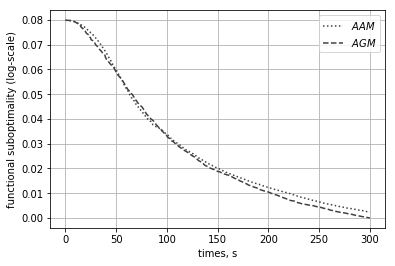

In [272]:
N = min(
    #len(fsin),
    len(faam),
    len(fagm)
)

f_opt = min(
    #np.min(fsin),
    np.min(faam),
    np.min(fagm)
)

begin = 0
end = min(taam[-1], tagm[-1])
#end = min(tsin[-1], taam[-1], tagm[-1])
#mask_sin = (tsin >= begin)*(tsin <= end)
mask_aam = (taam >= begin)*(taam <= end)
mask_agm = (tagm >= begin)*(tagm <= end)

f_opt = min(
    #np.min(fsin[mask_sin]),
    np.min(faam[mask_aam]),
    np.min(fagm[mask_agm])
)

fig, ax = plt.subplots()
#ax.plot(tsin[mask_sin], fsin[mask_sin]-f_opt, color='#404040', label='Sinkhorn')
ax.plot(taam[mask_aam], faam[mask_aam]-f_opt, color='#404040', linestyle='dotted', label=r'$AAM$')
ax.plot(tagm[mask_agm], fagm[mask_agm]-f_opt, color='#404040', linestyle='dashed', label=r'$AGM$')

plt.grid(True)
ax.set_xlabel('times, s')
ax.set_ylabel('functional suboptimality (log-scale)')
leg = ax.legend();
#plt.savefig('1e-3_ACC-SIN.png', dpi=200, bbox_extra_artists=(leg, ax), bbox_inches='tight')

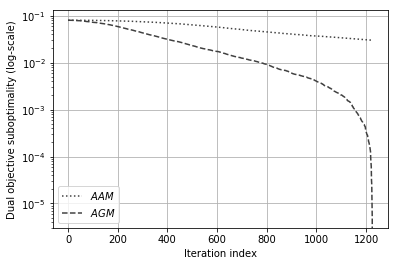

In [273]:
fig, ax = plt.subplots()
#ax.semilogy(fsin[:N]-f_opt, color='#404040', label='Sinkhorn')
ax.semilogy(faam[:N]-f_opt, color='#404040', linestyle='dotted', label=r'$AAM$')
ax.semilogy(fagm[:N]-f_opt, color='#404040', linestyle='dashed', label=r'$AGM$')
plt.grid(True)

ax.set_xlabel('Iteration index')
ax.set_ylabel('Dual objective suboptimality (log-scale)')
leg = ax.legend();
#plt.savefig('str-better.png', dpi=200, bbox_extra_artists=(leg, ax), bbox_inches='tight')